In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import skimage.measure
from scipy import ndimage as ndi
from scipy.stats import poisson
import pandas as pd

from analyfits import misc
from analyfits.manipufits import ManipulateFits
from analyfits import datafits

probabilidad = 0.2245

import gc # Garbage collector: Para ayudar a mantener la RAM limpia

In [2]:
DIR = "/home/igna/Escritorio/Tesis2021/Archivos/T123K"
#DIR_win = "D:\ignag\Igna\Facultad\Tesis2021\Archivos\T123K"
os.chdir(DIR)
fits_imgs_list = misc.fits_finder(DIR)

In [3]:
lista_data_dics, lista_data_idx_o = datafits.image2cluster_info_and_sim(fits_imgs_list, 
                                                                img="o",
                                                                low_th=2, upp_th=None,
                                                                ohdu=0)
df_data = datafits.df_gen(lista_data_dics, lista_data_idx_o)
del lista_data_dics, lista_data_idx_o
gc.collect()

100.00%

0

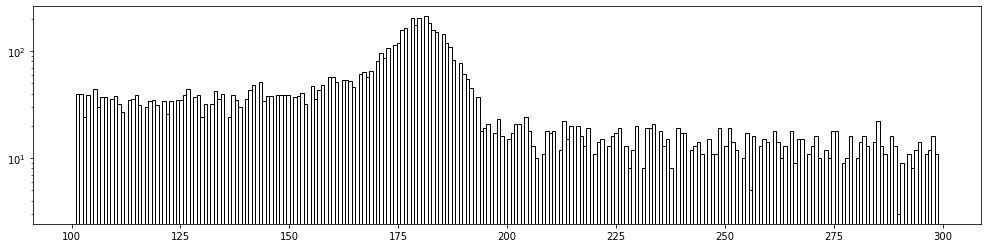

In [4]:
energia_data = df_data[(df_data["energia"]>100) & (df_data["energia"]<300)]["energia"]

plt.figure(figsize=(17,4))
plt.hist(energia_data, bins=250, fill=False);
plt.yscale("log")

# BORDES

Voy a hacer paso a paso el cálculo de los bordes, gracias a más códigos que me pasó Santiago Perez

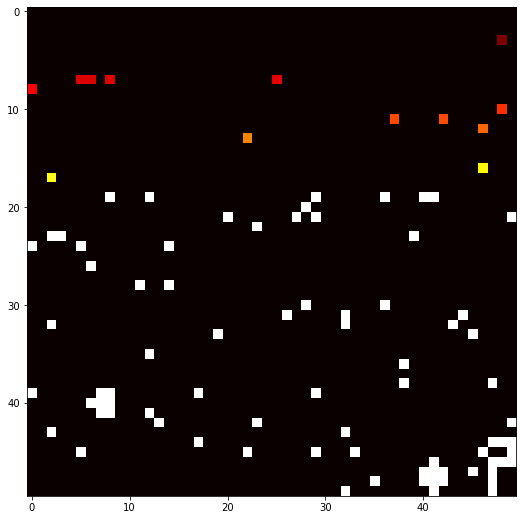

In [5]:
# agarro una imagen random
img_dir = fits_imgs_list[213]

# La transformo a matriz numpy

img = ManipulateFits().ADU2e(img_dir)

# binarizo
img_bw = misc.img2bw(img, low_th=2)

# Structura
struc = [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]

# Le busco los labels


img_label, count = ndi.label(img_bw, structure=struc)

# Miro solo una parte de la imagen

plt.figure(figsize=(9,9))
plt.imshow(img_label[0:50, 100:150], cmap="hot", vmin=0, vmax=200)

Dilato los clusters.

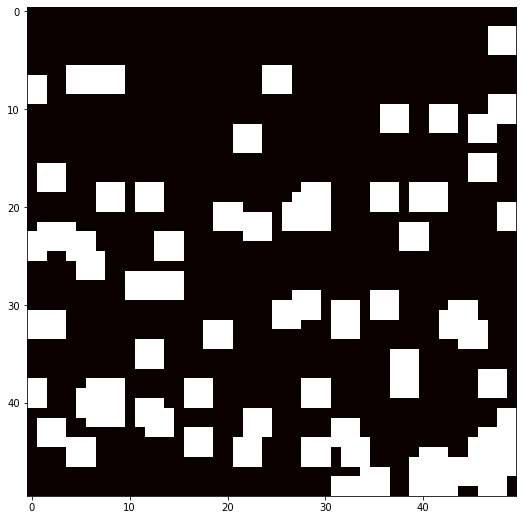

In [6]:
img_dilatada = ndi.morphology.binary_dilation(img_label, structure=struc)
plt.figure(figsize=(9, 9))
plt.imshow(img_dilatada[0:50, 100:150], cmap="hot")

Ahora miro la diferencia entre la imagen dilatada y la original

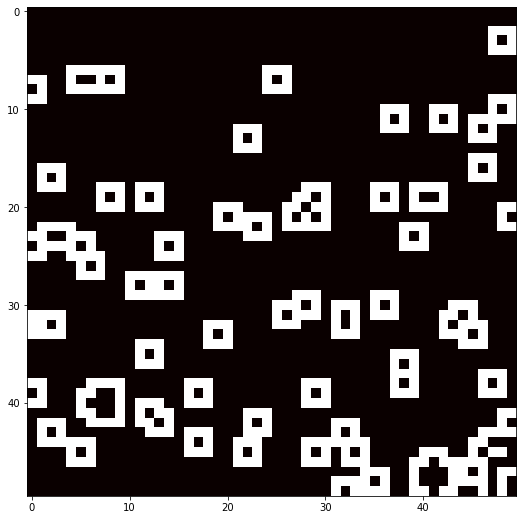

In [7]:
plt.figure(figsize=(9, 9))
bordes = (img_dilatada*1.0 - img_bw*1.0)
plt.imshow(bordes[0:50, 100:150], cmap="hot")

La imagen completa de los bordes

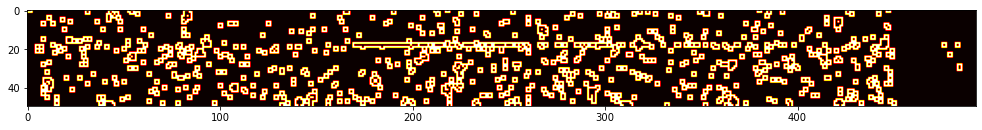

In [8]:
plt.figure(figsize=(17, 2))
plt.imshow(bordes, cmap="hot")

La relación entre los bordes y la cantidad total de píxeles es

In [9]:
np.sum(bordes)/bordes.size

0.21192697768762678

### ¿Qué quiero hacer?

- Tomo todas las imágenes y las paso a unidades de electrones usando como threshold 2
- Me quedo solo con los clusters que tienen carga enre 160 y 200 electrones. Todo lo demás lo mato.
- Dilato esos clusters
- Armo la máscara a partir de los clusters dilatados y la imagen sin dilatar
- Uso la máscara sobre las imagenes completas y cuento la carga que hay sobre ellos.
- Comparo la cantidad de carga sobre los bordes vs la carga esperada en esa cantidad de píxeles por dark current

In [10]:
def image_intensity(region, intensities):
    """
    Es una función interna de get_cluster_info
    Suma las intensidades de una region en unidades de electrones
    """
    return np.sum(intensities[region])

# agarro una imagen random
carga = 0
pixeles = 0
clusters_per_pic = []
for i, image in enumerate(fits_imgs_list):
    cluster_index = []
    # Cargo la iamgen original, equivalente a epix 0.5
    img = ManipulateFits().ADU2e(image)
    # binarizo con thresh=2 equivalente a epix 1.5
    img_bw = misc.img2bw(img, low_th=2)
    # Structura
    struc = [[1, 1, 1],
             [1, 1, 1],
             [1, 1, 1]]

    # Le busco los labels
    img_label, count = ndi.label(img_bw, structure=struc)
    
    # Usando los labels, voy a buscar los clusters que cumplan que
    # tienen entre 160 y 200 electrones
    rps = skimage.measure.regionprops(img_label,
                                      intensity_image=img,
                                      cache=False,
                                      extra_properties=[image_intensity])
    
    # Aprovecho y cuento la cantidad de clusters de 180 por imagen
    n_clusters = 0
    for r in rps:
        intens = r.image_intensity
        if intens >= 160 and intens <=200:
            cluster_index.append(1)
            n_clusters += 1
        else:
            cluster_index.append(0)
    # Appendeo el numero total de clusters contados por imagen
    clusters_per_pic.append(n_clusters)
    
    # Ahora, buscando en qué índice de la lista cluster_index hay 1's,
    # puedo matchearlo con el label del mismo valor que el número del
    # índice. Esos labels van a sobrevivir, los demás van a ser 0.

    # para eso, transformo la lista en array de numpy
    cluster_index_np = np.array(cluster_index)

    # Lista de vals/indices donde los clusters tienen ese rango de carga
    values = list(np.where(cluster_index_np==1)[0])

    # Me armo una lista con condiciones (arrays True/False)
    conditions = [img_label == value for value in values]

    # Ahora me armo la máscara solo en los clusters deseados, para eso
    # redefino la img_label. Equivale a haber encontrado solo clusters con
    # carga entre 160 y 200 electrones
    try:
        img_label = np.select(conditions, values)
         # Ahora dilato esos clusters
        img_dilat = ndi.morphology.binary_dilation(img_label, structure=struc)

        # Transformo a 0's y 1's la img_dilatada
        img_dilat = img_dilat*1#np.where(img_dilat!=0, 1, 0)

        # Transformo a 0's y 1's la img_label
        img_label = np.where(img_label!=0, 1, 0)

        # Hago la máscara usando la imagen dilatada y img_label
        mask = img_dilat - img_label

        # Se la aplico a la imagen original y sumo la carga
        img_bordes = img*mask
        carga += np.sum(img_bordes)

        # Se la aplico a la binarizada
        pixeles += np.sum(mask)
    except ValueError as e:
        print("\r\nimagen %i sin clusters entre 160 y 200 electrones" % i,end="")
        pass   
    print("\r %.2f%%" % ((i+1)*100/len(fits_imgs_list)), end="")

carga_oscura = pixeles*0.2245
diff_carga = carga_oscura - carga
mean_cluster = np.mean(clusters_per_pic)
std_cluster = np.std(clusters_per_pic)
print("\nCantidad de carga en bordes: %i" % carga)
print("Cantidad de carga esperada por corrientes oscuras: %i" % carga_oscura)
print("Diferencia de carga: %i" % diff_carga)
print("Diferencia promedio en 925 imágenes: %.2f" % (diff_carga/925))
print("\nPromedio clusters de 180 p/ imagen: %.2f +/- %.2f" % (mean_cluster, std_cluster))


 7.14% 0 sin clusters entre 160 y 200 electrones
 7.35% 66 sin clusters entre 160 y 200 electrones
 8.22% 68 sin clusters entre 160 y 200 electrones
 12.86%76 sin clusters entre 160 y 200 electrones
 25.51%119 sin clusters entre 160 y 200 electrones
 26.92%236 sin clusters entre 160 y 200 electrones
 31.78%249 sin clusters entre 160 y 200 electrones
 39.14%294 sin clusters entre 160 y 200 electrones
 46.16%362 sin clusters entre 160 y 200 electrones
 46.81%427 sin clusters entre 160 y 200 electrones
 49.19%433 sin clusters entre 160 y 200 electrones
 58.92%455 sin clusters entre 160 y 200 electrones
 60.97%545 sin clusters entre 160 y 200 electrones
 68.76%564 sin clusters entre 160 y 200 electrones
 69.41%636 sin clusters entre 160 y 200 electrones
 84.43%642 sin clusters entre 160 y 200 electrones
 84.97%781 sin clusters entre 160 y 200 electrones
 100.00%86 sin clusters entre 160 y 200 electrones
Cantidad de carga en bordes: 6538
Cantidad de carga esperada por corrientes oscuras: 7

In [11]:
carga = 0
pixeles = 0
cluster_index = []
image = fits_imgs_list[15]
# Cargo la imagen
img = ManipulateFits().ADU2e(image)
# binarizo con thresh=2 equivalente a epix 1.5
img_bw = misc.img2bw(img, low_th=2)
# Structura
struc = [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]

# Le busco los labels
img_label, count = ndi.label(img_bw, structure=struc)

# Usando los labels, voy a buscar los clusters que cumplan que
# tienen entre 160 y 200 electrones
rps = skimage.measure.regionprops(img_label,
                                  intensity_image=img,
                                  cache=False,
                                  extra_properties=[image_intensity])

for r in rps:
    intens = r.image_intensity
    if intens >= 160 and intens <=200:
        cluster_index.append(1)
    else:
        cluster_index.append(0)

# Ahora, buscando en qué índice de la lista cluster_index hay 1's,
# puedo matchearlo con el label del mismo valor que el número del
# índice. Esos labels van a sobrevivir, los demás van a ser 0.

# para eso, transformo la lista en array de numpy
cluster_index = np.array(cluster_index)

# Busco los vals/indices donde los clusters tienen ese rango de carga
values = list(np.where(cluster_index==1)[0])

# Me armo una lista con condiciones (arrays True False)
conditions = [img_label == value for value in values]

# Ahora me armo la máscara solo en los clusters deseados, para eso
# redefino la img_label
img_label = np.select(conditions, values)

# Ahora dilato
img_dilat = ndi.morphology.binary_dilation(img_label, structure=struc)

# Transformo a 0's y 1's la img_dilatada
img_dilat = np.where(img_dilat!=0, 1, 0)

# Transformo a 0's y 1's la img_label
img_label = np.where(img_label!=0, 1, 0)

# Hago la máscara usando la imagen dilatada y img_label
mask = img_dilat - img_label

# Se la aplico a la imagen original y sumo la carga
img_bordes = img*mask
carga += np.sum(img_bordes)

# Se la aplico a la binarizada
pixeles += np.sum(mask)
print("\nCantidad de carga en bordes: %i" % carga)
print("Cantidad de carga esperada por corrientes oscuras: %i" %(pixeles*0.2245))


Cantidad de carga en bordes: 23
Cantidad de carga esperada por corrientes oscuras: 17


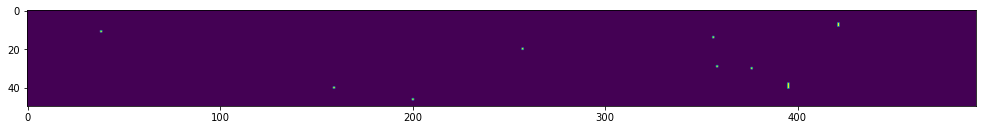

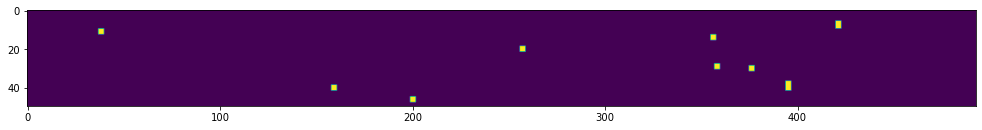

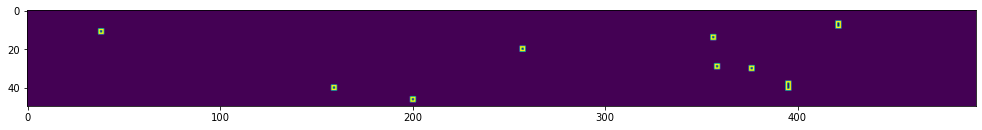

In [12]:
plt.figure(figsize=(17,2))
plt.imshow(img_label)
plt.figure(figsize=(17,2))
plt.imshow(img_dilat)
plt.figure(figsize=(17,2))
plt.imshow(mask)

In [ ]:
# ============================================================================

cargas_totales = 0
pixeles_totales = 0
clusters_per_pic = []
for i, image in enumerate(fits_imgs_list):
    carga, pixeles, n_clusters = datafits.border_events(image, low_th=2, ohdu=0)
    clusters_per_pic.append(n_clusters)
    cargas_totales += carga
    pixeles_totales += pixeles
    print("\r %.2f%% Completado. -" % ((i+1)*100/len(fits_imgs_list)), end="")

carga_oscura = pixeles_totales*0.2245*np.exp(-0.2245)
diff_carga = abs(carga_oscura - cargas_totales)
mean_cluster = np.mean(clusters_per_pic)
std_cluster = np.std(clusters_per_pic)
print("\nCantidad de carga en bordes: %i" % cargas_totales)
print("Cantidad de carga esperada por corrientes oscuras: %i" % carga_oscura)
print("Diferencia de carga: %i" % diff_carga)
print("Diferencia promedio en 925 imágenes: %.2f" % (diff_carga/925))
print("\nPromedio clusters de 180 p/ imagen: %.2f +/- %.2f" % (mean_cluster, std_cluster))

 64.22% Completado. -

# Prueba celda por celda

In [ ]:
def image_intensity(region, intensities):
    """
    Es una función interna de get_cluster_info
    Suma las intensidades de una region en unidades de electrones
    """
    return np.sum(intensities[region])

### Cargo y ploteo la imagen original

In [ ]:
carga = 0
pixeles = 0
image = fits_imgs_list[66]
# Cargo la imagen
img = ManipulateFits().ADU2e(image)
plt.figure(figsize=(17,5))
plt.title("IMAGEN ORIGINAL (epix=0.5)")
plt.imshow(img[:,350:450], cmap="hot", vmin=0, vmax=10);

### Binarizo y ploteo usando threshold 2 (epix=1.5)

In [ ]:
# binarizo con thresh=2 equivalente a epix 1.5
img_bw = misc.img2bw(img, low_th=2)
plt.figure(figsize=(17,5))
plt.title("IMAGEN FILTRADA (epix=1.5)")
plt.imshow(img_bw[:,350:450], cmap="hot", vmin=0, vmax=1);

In [ ]:
# Structura
struc = [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]

# Le busco los labels
img_label, count = ndi.label(img_bw, structure=struc)
plt.figure(figsize=(17,2))
plt.imshow(img_label)# cmap="hot", vmin=0, vmax=200)

### Filtro los clusters que no tienen carga entre 160 y 200 e

In [ ]:
# Usando los labels, voy a buscar los clusters que cumplan que
# tienen entre 160 y 200 electrones
rps = skimage.measure.regionprops(img_label,
                                  intensity_image=img,
                                  cache=False,
                                  extra_properties=[image_intensity])

cluster_index = []
cluster_intensity = []
for r in rps:
    intens = r.image_intensity
    if intens >= 160 and intens <=200:
        cluster_index.append(1)
        cluster_intensity.append(intens)
    else:
        cluster_index.append(0)

# Ahora, buscando en qué índice de la lista cluster_index hay 1's,
# puedo matchearlo con el label del mismo valor que el número del
# índice. Esos labels van a sobrevivir, los demás van a ser 0.

# para eso, transformo la lista en array de numpy
cluster_index_np = np.array(cluster_index)

# Busco los vals/indices donde los clusters tienen ese rango de carga
values = list(np.where(cluster_index_np==1)[0])

# Me armo una lista con condiciones (arrays True False)
conditions = [img_label == value for value in values]

# Ahora me armo la máscara solo en los clusters deseados, para eso
# redefino la img_label
try:
    img_label = np.select(conditions, values)
except ValueError as e:
    print(f"lista conditions vacía: len(conditions)={len(conditions)}")
    print("No se encontraron clusters con carga entre 160 y 200 e")
print(f"Numero de clusters encontrados: {len(cluster_intensity)}")
print(f"Intensidad de los clusters: {cluster_intensity}")
plt.figure(figsize=(17,5))
plt.imshow(img_label[:,350:450], cmap="hot", vmin=0, vmax=1);

### Dilato los clusters y ploteo

In [ ]:
# Ahora dilato
img_dilat = ndi.morphology.binary_dilation(img_label, structure=struc)
plt.figure(figsize=(17,5))
plt.imshow(img_dilat[:,350:450], cmap="hot", vmin=0, vmax=1);

### Armo la máscara de los bordes

In [ ]:
# Transformo a 0's y 1's la img_dilatada
img_dilat = np.where(img_dilat!=0, 1, 0)

# Transformo a 0's y 1's la img_label
img_label = np.where(img_label!=0, 1, 0)

# Hago la máscara usando la imagen dilatada y img_label
plt.figure(figsize=(17,5))
plt.imshow(mask[:,350:450], cmap="hot", vmin=0, vmax=1);

### Aplico la máscara a la imagen original y ploteo

In [ ]:
# Se la aplico a la imagen original y sumo la carga
img_bordes = img*mask
plt.figure(figsize=(17,5))
plt.imshow(img_bordes[:,350:450], cmap="hot");

In [ ]:
carga = np.sum(img_bordes)

# Se la aplico a la binarizada
pixeles = np.sum(mask)
print("\nCantidad de carga en bordes: %i" % carga)
print("Cantidad de carga esperada por corrientes oscuras: %i" %(pixeles*0.2245))

### Miro los bordes superpuestos a los clusters sin expandir

In [ ]:
# normalizo intensidad de img_label a 5 (arbitrario)
img_label = np.where(img_label!=0, 5, 0)
# Sumo img_bords e img_label para verlas superpuestas
imagen = img_label + img_bordes
plt.figure(figsize=(17,5))
plt.imshow(imagen[:,350:450], cmap="hot", vmin=0, vmax=5);

In [ ]:
img_bordes.sum()

In [ ]:
import random
image = random.choice(fits_imgs_list)
carga, pixeles, n_clusters = datafits.border_events(image, low_th=2, ohdu=0)

carga_bordes = carga
carga_esperada = pixeles*0.2245
print(f"Carga en bordes: {carga_bordes}")
print(f"Carga en esperada: {carga_esperada}")

In [ ]:
carga_borde_lista = []
carga_esperada_lista = []
acumulativo = 0
acumulativo_esperado = 0
acumulativo_list = []
acumulativo_esperado_list = []
for i, image in enumerate(fits_imgs_list):
    carga, pixeles, n_clusters = datafits.border_events(image, low_th=2, ohdu=0)
    carga_borde_lista.append(carga)
    carga_esperada_lista.append(pixeles*0.2245)
    acumulativo += carga
    acumulativo_list.append(acumulativo)
    acumulativo_esperado += pixeles*0.2245
    acumulativo_esperado_list.append(acumulativo_esperado)
    print("\r%.2f%%" %((i+1)*100/len(fits_imgs_list)), end="")

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(carga_borde_lista, label = "Real")
plt.plot(carga_esperada_lista, label = "Esperada")
plt.legend(fontsize=20)

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(acumulativo_list, label = "Real")
plt.plot(acumulativo_esperado_list, label = "Esperada")
plt.legend(fontsize=20)

In [ ]:
np.array(carga_borde_lista).mean(), np.array(carga_borde_lista).std()

In [ ]:
np.array(carga_esperada_lista).mean(), np.array(carga_esperada_lista).std()